In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [9]:
def format_snps(old_df, alt_col):                                               
    multirow = old_df[alt_col].str.split(',').apply(Series, 1).stack()          
    multirow.index = multirow.index.droplevel(-1)                               
    multirow.name = alt_col                                                     
    x = old_df.columns                                                          
    del old_df[alt_col]                                                         
    new_df = old_df.join(multirow)                                              
    new_df = new_df[x]                                                          
    return new_df

## Filter Original GWAS on P-value

In [ ]:
basefilename = '/mnt/lab_data3/soumyak/adpd/gwas/'
for fold in range(10):
    print(fold)
    for gwas_file in ['23andme_PD.formatted.txt.', 'GWAS_Kunkle2019.formatted.txt.']:
        gwas = pd.read_csv(basefilename+gwas_file+str(fold), sep='\t', keep_default_na=False)
        new_gwas = gwas.loc[gwas['PVALUE'] < 5e-8]
        new_gwas.to_csv(basefilename+gwas_file+'5e-8.'+str(fold), sep='\t', index=False)

## Get all SNPs around P-value filtered SNP

In [122]:
basefilename = '/mnt/lab_data3/soumyak/adpd/gwas/'
for fold in range(10):
    for gwas_file in ['23andme_PD.formatted.txt.', 'GWAS_Kunkle2019.formatted.txt.']:
        gwas = pd.read_csv(basefilename+gwas_file+'5e-8.'+str(fold), sep='\t', keep_default_na=False)
        gwas['START'] = gwas['START'] - 4999
        gwas['END'] = gwas['END'] + 5000
        gwas_bed = pybedtools.BedTool.from_dataframe(gwas)
        orig_gwas = pybedtools.BedTool(basefilename+gwas_file+str(fold))
        ld_buddies = orig_gwas.intersect(gwas_bed, u=True)
        if ld_buddies.count() != 0:
            ld_df = pybedtools.BedTool.to_dataframe(ld_buddies)
            ld_df.columns = gwas.columns
            new_ld_df = format_snps(ld_df, 'ALT')
            new_ld_df.to_csv(basefilename+gwas_file+'ld_buddies'+str(fold), sep='\t', index=False)

## Constant Addresses

In [9]:
ref_fasta='/mnt/data/annotations/by_release/hg19/male.hg19.fa'
snp_prefix='/mnt/lab_data3/soumyak/adpd/gwas'

## Get Predictions

In [10]:
def get_preds_all_folds(task, gwas, ref_fasta=ref_fasta, snp_prefix=snp_prefix, n_folds=10):
    
    if gwas == 'AD':
        all_snps_basename='GWAS_Kunkle2019.formatted.txt.ld_buddies'
    else:
        all_snps_basename='23andme_PD.formatted.txt.ld_buddies'

    model_prefix=model_dict[task]
    idr_peaks=idr_dict[task]
    
    for fold in range(n_folds): 
        snp_file='/'.join([snp_prefix,all_snps_basename])+str(fold)
        if os.path.exists(snp_file):
            print(fold)
            #load the model
            custom_objects={"recall":recall,
                            "sensitivity":recall,
                            "specificity":specificity,
                            "fpr":fpr,
                            "fnr":fnr,
                            "precision":precision,
                            "f1":f1,
                            "ambig_binary_crossentropy":ambig_binary_crossentropy,
                            "ambig_mean_squared_error":ambig_mean_squared_error}
            model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
            print("loaded model")
            #get reference allele predictions 
            snp_ref_generator=SNPGenerator(data_path=snp_file,
                                           ref_fasta=ref_fasta,
                                           allele_col="REF")
            snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                        max_queue_size=5000, 
                                                        workers=40, 
                                                        use_multiprocessing=True,
                                                        verbose=1)
            print("got snp ref predictions")
            #get alternate allele predictions 
            snp_alt_generator=SNPGenerator(snp_file,
                                           ref_fasta=ref_fasta,
                                           allele_col="ALT")
            snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                        max_queue_size=5000, 
                                                        workers=40, 
                                                        use_multiprocessing=True, verbose=1)
            print("got snp alt predictions")
            snp_ref_generator.data['ref_pred']=snp_ref_predictions
            snp_ref_generator.data['alt_pred']=snp_alt_predictions
            snp_ref_generator.data.to_csv(task+'.'+str(fold)+'.MYGWAS_SNP_predictions.txt',sep='\t')

In [11]:
get_preds_all_folds('PD_GBA1_MDTG', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 5s 1s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 4s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 5s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 4s 1s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 5s 3s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 4s 2s/step
g

In [12]:
get_preds_all_folds('PD_CTRL_SUNI', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 7s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 4s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 7s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 4s 1s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 7s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 4s 2s/step
g

In [ ]:
get_preds_all_folds('PD_GBA1_SUNI', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 8s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 5s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 8s 3s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 5s 2s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 8s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 5s 3s/step
g

In [ ]:
get_preds_all_folds('AD_CTRL_SMTG','AD')

In [ ]:
get_preds_all_folds('AD_ADAD_SMTG','AD')

In [ ]:
get_preds_all_folds('AD_CTRL_PARL','AD')

In [ ]:
get_preds_all_folds('AD_ADAD_PARL','AD')

In [ ]:
get_preds_all_folds('AD_CTRL_HIPP','AD')

In [ ]:
get_preds_all_folds('PD_CTRL_HIPP','PD')

In [ ]:
get_preds_all_folds('PD_GBA1_HIPP','PD')

## Get Results from all Folds

In [7]:
def get_results_all_folds(task):
    print("TASK: ",task)
    for fold in range(10):
        snp_file = task+'.'+str(fold)+'.MYGWAS_SNP_predictions.txt'
        if os.path.exists(snp_file):
            print("FOLD: ",fold)
            snp_predictions=pd.read_csv(snp_file,sep='\t')
            print("All SNPs:")
            display(snp_predictions.shape)
            snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
            idr_bed = pybedtools.BedTool(idr_peaks)
            pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
            if pos_snps_bed.count() > 0:
                pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
                pos_snps.columns = snp_predictions.columns
                print("SNPs in Peaks:")
                display(pos_snps.shape)
                plotnine.options.figure_size = (6,6)
                display((ggplot(pos_snps,
                    aes(x="ref_pred",y="alt_pred",label='RSID'))+
                geom_point(alpha=0.3,color='red')+
                theme_bw(20)+
                xlab("Reference Allele Prediction")+
                ylab("Alternate Allele Prediction")+
                ggtitle("GWAS Variants")))
                pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
                pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])
                print("Negative SNPs in Peaks:")
                display(pos_snp_predictions_sorted.head(10))
                print("Positive SNPs in Peaks:")
                display(pos_snp_predictions_sorted.tail(10))
            snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
            idr_bed = pybedtools.BedTool(idr_peaks)
            neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
            if neg_snps_bed.count() > 0:
                neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
                neg_snps.columns = snp_predictions.columns
                print("SNPs NOT in Peaks:")
                display(neg_snps.shape)
                plotnine.options.figure_size = (6,6)
                display((ggplot(neg_snps,
                    aes(x="ref_pred",y="alt_pred",label='RSID'))+
                geom_point(alpha=0.3,color='red')+
                theme_bw(20)+
                xlab("Reference Allele Prediction")+
                ylab("Alternate Allele Prediction")+
                ggtitle("GWAS Variants")))
                neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
                neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])
                print("Negative SNPs OUTSIDE Peaks:")
                display(neg_snp_predictions_sorted.head(10))
                print("Positive SNPs OUTSIDE Peaks:")
                display(neg_snp_predictions_sorted.tail(10))

TASK:  PD_CTRL_MDTG
FOLD:  0
All SNPs:


(446, 12)

SNPs in Peaks:


(38, 12)

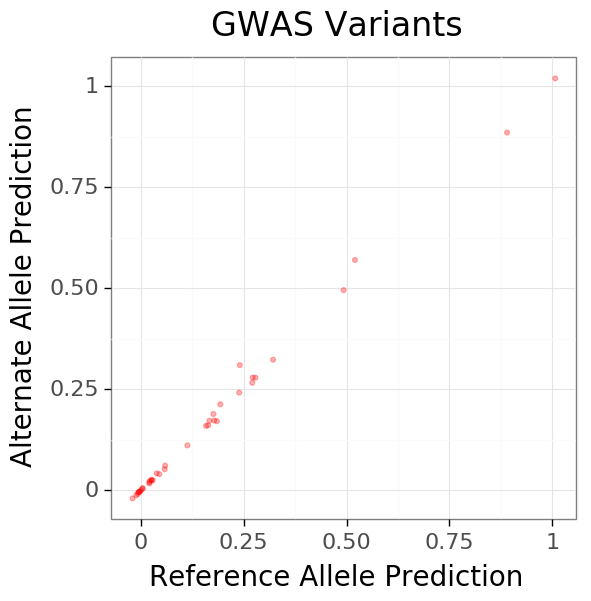

<ggplot: (-9223363249135826295)>

Negative SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
6   chr1  155135335  155135336    rs4460629   C   T  9.149490e-01  0.002004   
5   chr1  155135036  155135037   rs35749011   A   G  5.326700e-14 -0.536007   
13  chr1  155207549  155207550     rs762488   C   T  6.654640e-01  0.008818   
35  chr1  205670871  205670872   rs12751694   A   G  7.916090e-01  0.051321   
1   chr1  154983930  154983931   rs77982133   C   T  4.117510e-01  0.038985   
12  chr1  155207367  155207368   rs74500255   A   T  2.015240e-01  1.753920   
18  chr1  155208006  155208007     rs364897   C   T  2.004270e-01 -1.170800   
31  chr1  155822971  155822972     rs822490   C   T  1.005310e-01 -0.032386   
27  chr1  155822578  155822579  rs191848370   A   G  6.280000e-01 -0.087976   
36  chr1  205671001  205671002  rs116664067   A   T  5.785580e-01  0.050852   

          SE PASS  ref_pred  alt_pred     delta  
6   0.018767    Y  0.184915  0.171194 -0.013721  
5   0.066947    Y  0.057969  0.052282 -0.005687  
13  0.020404    Y  0.178393  0.172842 -0.005551  
35  0.195357    Y  0.890088  0.885170 -0.004917  
1   0.047293    Y  0.270740  0.266005 -0.004735  
12  1.169310    Y  0.044837  0.040164 -0.004673  
18  0.809268    Y  0.028772  0.024702 -0.004070  
31  0.019693    Y  0.020869  0.016905 -0.003964  
27  0.179494    Y  0.163508  0.160790 -0.002719  
36  0.092143    Y  0.113087  0.111227 -0.001860

Positive SNPs in Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
9   chr1  155140023  155140024  rs114413971   A   C  0.326770  0.045034   
28  chr1  155822629  155822630  rs112685832   A   C  0.260298  0.037156   
17  chr1  155207985  155207986   rs74462743   C   T  0.144436  2.080070   
37  chr1  205671167  205671168    rs1417725   A   G  0.022548  0.114527   
14  chr1  155207626  155207627    rs2009578   A   G  0.882222  0.003030   
34  chr1  205670726  205670727     rs823098   A   G  0.114962  0.079276   
19  chr1  155208361  155208362  rs147138516   C   G  0.014743  1.417620   
26  chr1  155822529  155822530   rs13376235   A   G  0.521447 -0.028032   
10  chr1  155140027  155140028   rs12131522   C   T  0.958053  0.000990   
33  chr1  205670369  205670370    rs6673687   A   T  0.000008 -0.086770   

          SE PASS  ref_pred  alt_pred     delta  
9   0.046174    Y  0.492831  0.495317  0.002486  
28  0.033118    Y  0.239030  0.241750  0.002720  
17  1.183400    Y  0.038514  0.042045  0.003532  
37  0.050882    Y  0.166853  0.172119  0.005266  
14  0.020456    Y  0.271964  0.278992  0.007028  
34  0.050799    Y  1.007172  1.019161  0.011990  
19  0.495539    Y  0.176430  0.188875  0.012445  
26  0.043575    Y  0.193116  0.212857  0.019741  
10  0.018828    Y  0.520425  0.569928  0.049503  
33  0.019520    Y  0.240522  0.309740  0.069218

SNPs NOT in Peaks:


(408, 12)

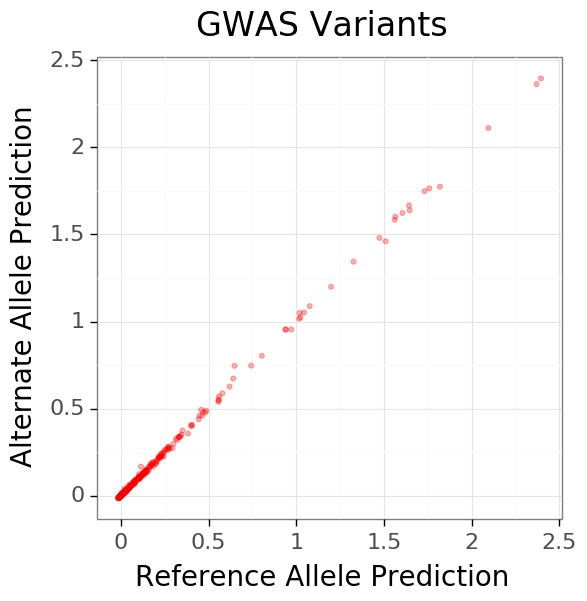

<ggplot: (-9223363250152596350)>

Negative SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
316  chr1  205718858  205718859    rs7536483   A   T  4.290230e-02  0.038184   
85   chr1  155113074  155113075   rs12745576   A   C  9.734980e-01 -0.001967   
28   chr1  154914552  154914553    rs6690352   C   T  2.598440e-01  0.542296   
37   chr1  154916380  154916381  rs190798318   C   T  3.521610e-01 -0.239792   
89   chr1  155115260  155115261    rs4246529   C   T  9.256370e-02  0.032142   
81   chr1  155109973  155109974  rs144486053   G   T  2.418940e-01 -0.090938   
407  chr1  205744218  205744219    rs1572931   C   T  8.115450e-02 -0.047969   
157  chr1  155205378  155205379   rs12752133   C   T  1.240970e-13  0.553975   
11   chr1  154911651  154911652    rs4845694   C   G  7.796100e-01  0.005313   
285  chr1  205674637  205674638  rs114794039   A   G  1.524520e-01  0.097961   

           SE PASS  ref_pred  alt_pred     delta  
316  0.018846    Y  1.509446  1.460546 -0.048899  
85   0.059259    Y  1.818723  1.774218 -0.044506  
28   0.450027    Y  0.382727  0.356677 -0.026051  
37   0.264808    Y  0.293364  0.271789 -0.021575  
89   0.019125    Y  0.243777  0.224200 -0.019577  
81   0.078615    Y  0.971221  0.953358 -0.017863  
407  0.027636    Y  0.555501  0.539202 -0.016300  
157  0.070121    Y  0.197836  0.182603 -0.015233  
11   0.018987    Y  0.150899  0.135845 -0.015054  
285  0.069256    Y  0.182289  0.167428 -0.014861

Positive SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
223  chr1  155412037  155412038   rs11264371   C   T  0.578178  0.012187   
51   chr1  154987526  154987527   rs11264295   C   T  0.973705 -0.000623   
58   chr1  154990297  154990298    rs2242194   C   G  0.757144 -0.006030   
144  chr1  155139509  155139510    rs7556304   C   T  0.938406  0.001451   
315  chr1  205718810  205718811   rs12727532   C   T  0.454834 -0.208047   
314  chr1  205718468  205718469   rs12047038   A   G  0.001904 -0.067468   
93   chr1  155118588  155118589  rs147847496   C   T  0.840517  0.012015   
4    chr1  154910012  154910013     rs877343   A   G  0.762849  0.005721   
286  chr1  205674897  205674898  rs111299170   C   T  0.329323 -0.034498   
0    chr1  154909169  154909170   rs17356361   C   T  0.276788  0.055702   

           SE PASS  ref_pred  alt_pred     delta  
223  0.021899    Y  0.019365  0.040089  0.020725  
51   0.018902    Y  0.351118  0.374194  0.023076  
58   0.019504    Y  1.643215  1.666491  0.023276  
144  0.018780    Y  1.561024  1.584467  0.023443  
315  0.284532    Y  1.018890  1.049558  0.030668  
314  0.021833    Y  0.640878  0.672544  0.031666  
93   0.059622    Y  0.458236  0.492841  0.034605  
4    0.018957    Y  1.565254  1.602016  0.036762  
286  0.035505    Y  0.114593  0.166609  0.052017  
0    0.050864    Y  0.648009  0.745719  0.097710

FOLD:  1
All SNPs:


(313, 12)

SNPs in Peaks:


(9, 12)

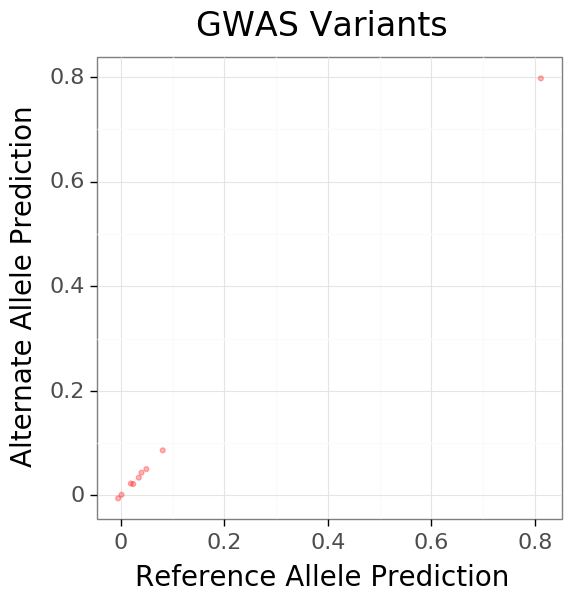

<ggplot: (-9223363250152661774)>

Negative SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
0  chr2  169109956  169109957   rs13002388   A   G  6.338120e-01 -0.012918   
4  chr2  169110621  169110622   rs12622375   A   G  2.420800e-03 -0.057436   
1  chr2  169110394  169110395    rs1474055   C   T  1.112500e-11  0.184632   
8  chr2  169132643  169132644   rs67058614   D   I  3.756770e-01  0.024522   
7  chr2  169132611  169132612   rs77548116   C   T  7.952470e-01  0.012166   
2  chr2  169110422  169110423  rs147610000   C   T  5.147330e-02 -0.088236   
6  chr2  169131721  169131722     rs955896   A   T  3.743930e-01  0.024463   
5  chr2  169131135  169131136  rs183501421   C   T  3.234590e-01 -0.195448   
3  chr2  169110500  169110501   rs12474289   A   G  7.941460e-01  0.128192   

         SE PASS  ref_pred  alt_pred     delta  
0  0.027152    Y  0.811750  0.797279 -0.014472  
4  0.018949    Y  0.023622  0.021800 -0.001822  
1  0.026727    Y  0.034377  0.033897 -0.000480  
8  0.027746    Y -0.005638 -0.005638  0.000000  
7  0.046951    Y  0.000992  0.001195  0.000203  
2  0.045731    Y  0.049012  0.050315  0.001302  
6  0.027606    Y  0.018978  0.022820  0.003842  
5  0.202374    Y  0.039534  0.043535  0.004000  
3  0.499616    Y  0.080622  0.086232  0.005609

Positive SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
0  chr2  169109956  169109957   rs13002388   A   G  6.338120e-01 -0.012918   
4  chr2  169110621  169110622   rs12622375   A   G  2.420800e-03 -0.057436   
1  chr2  169110394  169110395    rs1474055   C   T  1.112500e-11  0.184632   
8  chr2  169132643  169132644   rs67058614   D   I  3.756770e-01  0.024522   
7  chr2  169132611  169132612   rs77548116   C   T  7.952470e-01  0.012166   
2  chr2  169110422  169110423  rs147610000   C   T  5.147330e-02 -0.088236   
6  chr2  169131721  169131722     rs955896   A   T  3.743930e-01  0.024463   
5  chr2  169131135  169131136  rs183501421   C   T  3.234590e-01 -0.195448   
3  chr2  169110500  169110501   rs12474289   A   G  7.941460e-01  0.128192   

         SE PASS  ref_pred  alt_pred     delta  
0  0.027152    Y  0.811750  0.797279 -0.014472  
4  0.018949    Y  0.023622  0.021800 -0.001822  
1  0.026727    Y  0.034377  0.033897 -0.000480  
8  0.027746    Y -0.005638 -0.005638  0.000000  
7  0.046951    Y  0.000992  0.001195  0.000203  
2  0.045731    Y  0.049012  0.050315  0.001302  
6  0.027606    Y  0.018978  0.022820  0.003842  
5  0.202374    Y  0.039534  0.043535  0.004000  
3  0.499616    Y  0.080622  0.086232  0.005609

SNPs NOT in Peaks:


(304, 12)

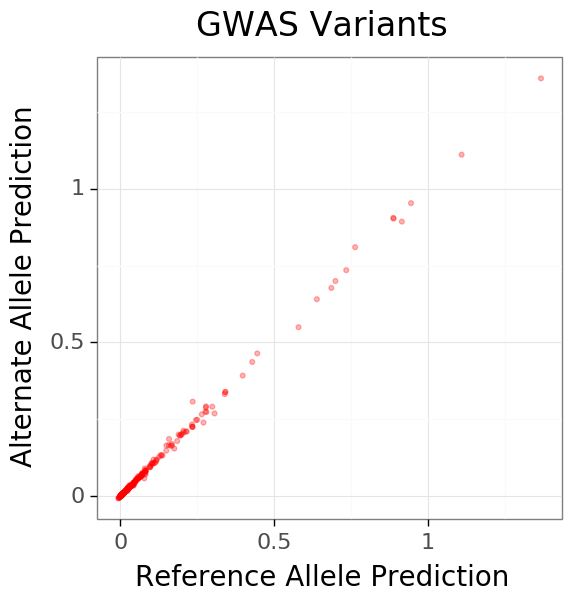

<ggplot: (8786702083655)>

Negative SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
2    chr2  169087232  169087233   rs16855155   A   G  4.915430e-01 -0.117109   
62   chr2  169096718  169096719   rs13401489   G   T  6.194720e-03  0.051431   
203  chr2  169147533  169147534    rs2138754   C   T  4.890620e-02 -0.036881   
12   chr2  169088773  169088774    rs1878485   G   T  8.766850e-01  0.008866   
86   chr2  169106699  169106700   rs74271810   C   G  9.943820e-01 -0.000962   
249  chr2  169155460  169155461   rs13432275   A   C  7.537470e-03  0.053040   
226  chr2  169151572  169151573   rs10930319   C   G  4.326780e-02 -0.037820   
80   chr2  169104348  169104349  rs181364589   A   T  7.559290e-01  0.060341   
201  chr2  169147029  169147030   rs78166116   A   G  3.485210e-01 -0.206268   
79   chr2  169103999  169104000   rs76179989   G   T  9.560470e-12 -0.185191   

           SE PASS  ref_pred  alt_pred     delta  
2    0.167852    Y  0.306345  0.269296 -0.037050  
62   0.018802    Y  0.270337  0.239500 -0.030836  
203  0.018724    Y  0.579561  0.549499 -0.030062  
12   0.057200    Y  0.915769  0.892627 -0.023142  
86   0.136617    Y  0.175338  0.155024 -0.020313  
249  0.019896    Y  0.077613  0.058161 -0.019452  
226  0.018710    Y  0.081970  0.071356 -0.010614  
80   0.195246    Y  1.368445  1.358010 -0.010435  
201  0.215022    Y  0.235068  0.225236 -0.009831  
79   0.026721    Y  0.686267  0.676972 -0.009295

Positive SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
93   chr2  169109230  169109231   rs10930318   C   T  0.678427 -0.011262   
85   chr2  169106176  169106177  rs114802580   A   G  0.256585 -0.162802   
77   chr2  169103143  169103144   rs73013478   C   T  0.632657 -0.015436   
64   chr2  169096810  169096811  rs116311695   C   G  0.161103  0.089341   
298  chr2  169169589  169169590  rs115802045   C   T  0.916351  0.016400   
182  chr2  169140909  169140910    rs4458184   A   C  0.564476  0.016130   
63   chr2  169096765  169096766    rs1517323   C   T  0.063687 -0.039536   
303  chr2  169171245  169171246   rs58843270   A   G  0.000206 -0.146987   
268  chr2  169158403  169158404    rs1517340   A   G  0.013007 -0.046962   
181  chr2  169140638  169140639    rs6741911   A   C  0.609587 -0.014043   

           SE PASS  ref_pred  alt_pred     delta  
93   0.027194    Y  0.079242  0.090675  0.011434  
85   0.140754    Y  0.107553  0.119243  0.011690  
77   0.032347    Y  0.888943  0.902255  0.013312  
64   0.063100    Y  0.278727  0.292337  0.013610  
298  0.157416    Y  0.149602  0.165239  0.015637  
182  0.028039    Y  0.887945  0.904875  0.016930  
63   0.021375    Y  0.445228  0.464373  0.019145  
303  0.038954    Y  0.158183  0.186466  0.028282  
268  0.018924    Y  0.763787  0.809558  0.045771  
181  0.027537    Y  0.235211  0.307638  0.072427

FOLD:  2
All SNPs:


(212, 12)

SNPs in Peaks:


(12, 12)

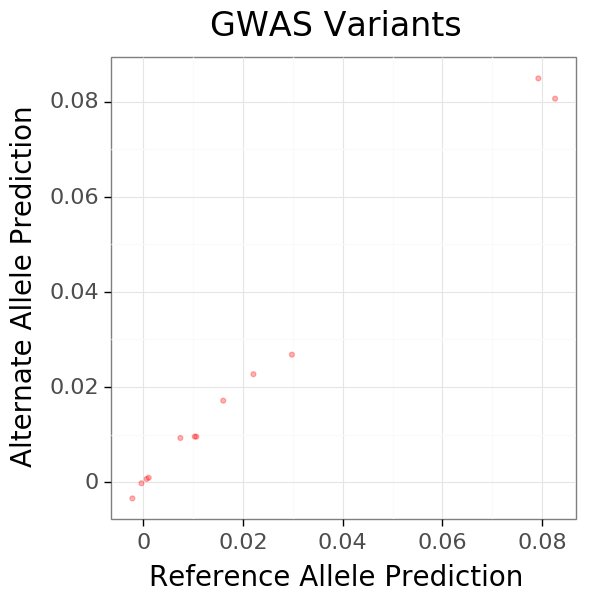

<ggplot: (-9223363250026557545)>

Negative SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
1   chr3  182710680  182710681    rs4859261   C   T  4.221840e-08  0.111944   
8   chr3  182739836  182739837   rs77458140   G   T  7.987470e-01 -0.014804   
5   chr3  182714378  182714379  rs186753914   A   G  3.377360e-01 -0.142495   
7   chr3  182739778  182739779  rs182753925   C   T  9.171920e-02 -0.295525   
4   chr3  182713941  182713942   rs74902465   A   G  4.302800e-08 -0.112069   
11  chr3  182740801  182740802   rs73883999   C   T  9.454170e-02  0.421845   
10  chr3  182740762  182740763  rs146449896   D   I  9.030890e-02 -0.427681   
2   chr3  182710940  182710941   rs78126209   A   G  8.569130e-01  0.010954   
3   chr3  182711005  182711006  rs144166036   G   T  3.460340e-01 -0.428322   
0   chr3  182710489  182710490  rs147515099   A   G  5.579360e-01 -0.044117   

          SE PASS  ref_pred  alt_pred     delta  
1   0.020551    Y  0.029803  0.026806 -0.002997  
8   0.058171    Y  0.082623  0.080658 -0.001966  
5   0.146379    Y -0.002203 -0.003425 -0.001221  
7   0.181985    Y  0.010622  0.009563 -0.001059  
4   0.020585    Y  0.010320  0.009565 -0.000754  
11  0.267292    Y  0.001074  0.000920 -0.000154  
10  0.267704    Y  0.000657  0.000657  0.000000  
2   0.060833    Y -0.000383 -0.000245  0.000137  
3   0.478385    Y  0.022091  0.022692  0.000601  
0   0.074948    Y  0.016035  0.017133  0.001098

Positive SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
5   chr3  182714378  182714379  rs186753914   A   G  3.377360e-01 -0.142495   
7   chr3  182739778  182739779  rs182753925   C   T  9.171920e-02 -0.295525   
4   chr3  182713941  182713942   rs74902465   A   G  4.302800e-08 -0.112069   
11  chr3  182740801  182740802   rs73883999   C   T  9.454170e-02  0.421845   
10  chr3  182740762  182740763  rs146449896   D   I  9.030890e-02 -0.427681   
2   chr3  182710940  182710941   rs78126209   A   G  8.569130e-01  0.010954   
3   chr3  182711005  182711006  rs144166036   G   T  3.460340e-01 -0.428322   
0   chr3  182710489  182710490  rs147515099   A   G  5.579360e-01 -0.044117   
6   chr3  182739738  182739739   rs11928508   C   G  4.694950e-08  0.113244   
9   chr3  182739950  182739951   rs73883998   C   T  8.534280e-02  0.433547   

          SE PASS  ref_pred  alt_pred     delta  
5   0.146379    Y -0.002203 -0.003425 -0.001221  
7   0.181985    Y  0.010622  0.009563 -0.001059  
4   0.020585    Y  0.010320  0.009565 -0.000754  
11  0.267292    Y  0.001074  0.000920 -0.000154  
10  0.267704    Y  0.000657  0.000657  0.000000  
2   0.060833    Y -0.000383 -0.000245  0.000137  
3   0.478385    Y  0.022091  0.022692  0.000601  
0   0.074948    Y  0.016035  0.017133  0.001098  
6   0.020874    Y  0.007427  0.009282  0.001855  
9   0.267406    Y  0.079260  0.084916  0.005656

SNPs NOT in Peaks:


(200, 12)

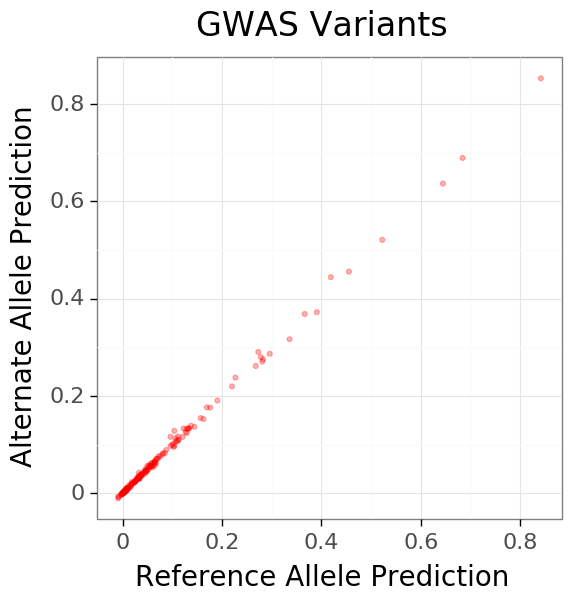

<ggplot: (-9223363250152629472)>

Negative SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
66   chr3  182729103  182729104   rs12496089   G   T  9.055830e-01 -0.006024   
67   chr3  182729141  182729142  rs116438848   A   G  4.600150e-01  0.061375   
101  chr3  182737208  182737209    rs1135365   A   T  6.764830e-01 -0.015106   
31   chr3  182718334  182718335  rs189240771   A   G  9.633470e-01  0.023232   
71   chr3  182729625  182729626   rs57575693   A   G  3.942610e-01  0.309809   
69   chr3  182729531  182729532   rs77687927   G   T  8.083060e-01 -0.041156   
64   chr3  182728580  182728581  rs142457109   C   T  2.532620e-01 -0.428124   
129  chr3  182748495  182748496   rs10937108   A   T  4.053010e-10 -0.150923   
75   chr3  182730772  182730773  rs186945002   G   T  7.851590e-01 -0.033262   
74   chr3  182730348  182730349  rs188817002   A   T  2.585330e-02  0.496198   

           SE PASS  ref_pred  alt_pred     delta  
66   0.050753    Y  0.336144  0.316811 -0.019333  
67   0.083598    Y  0.390845  0.372211 -0.018635  
101  0.036138    Y  0.281176  0.270800 -0.010376  
31   0.536104    Y  0.162771  0.152821 -0.009950  
71   0.377993    Y  0.296266  0.286900 -0.009366  
69   0.170430    Y  0.644739  0.636334 -0.008405  
64   0.394626    Y  0.144743  0.136977 -0.007766  
129  0.024465    Y  0.103210  0.095614 -0.007596  
75   0.122523    Y  0.282733  0.275395 -0.007338  
74   0.235008    Y  0.061269  0.054156 -0.007113

Positive SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
181  chr3  182761828  182761829   rs57211814   C   T  1.374020e-01  0.514338   
1    chr3  182704187  182704188   rs73066937   C   T  1.089850e-01 -0.573422   
78   chr3  182732230  182732231    rs9290751   A   G  4.032660e-10 -0.151436   
191  chr3  182763652  182763653    rs3772721   A   C  9.513320e-01  0.003558   
152  chr3  182753388  182753389  rs114588304   A   G  7.310890e-01 -0.282310   
154  chr3  182754574  182754575   rs10937109   A   G  6.397410e-01 -0.016941   
190  chr3  182763580  182763581    rs1502762   A   G  6.601880e-05 -0.092512   
102  chr3  182737509  182737510    rs6443842   A   G  6.769160e-01 -0.015084   
41   chr3  182721367  182721368   rs76575391   C   G  7.271710e-01 -0.020656   
50   chr3  182725046  182725047   rs76823265   C   G  7.680770e-01  0.017398   

           SE PASS  ref_pred  alt_pred     delta  
181  0.323222    Y  0.049947  0.056949  0.007002  
1    0.332846    Y  0.169475  0.176827  0.007352  
78   0.024546    Y  0.032963  0.042492  0.009529  
191  0.058394    Y  0.841832  0.852235  0.010404  
152  0.795366    Y  0.227184  0.237893  0.010709  
154  0.036122    Y  0.122653  0.133403  0.010750  
190  0.023362    Y  0.273133  0.290621  0.017488  
102  0.036138    Y  0.096383  0.116177  0.019795  
41   0.059355    Y  0.104260  0.128621  0.024362  
50   0.059124    Y  0.419081  0.444097  0.025017

FOLD:  3
All SNPs:


(90, 12)

SNPs NOT in Peaks:


(90, 12)

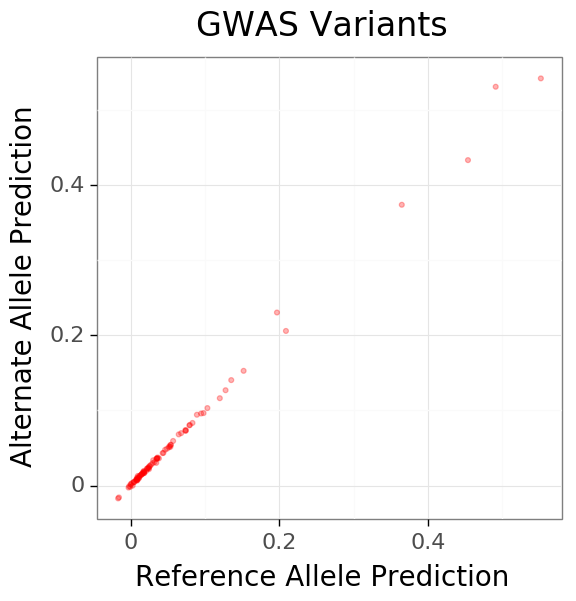

<ggplot: (8786702081670)>

Negative SNPs OUTSIDE Peaks:


CHR     START       END         RSID REF ALT        PVALUE      BETA  \
13  chr6  27671662  27671663  rs112219934   A   G  7.545050e-01  0.113176   
11  chr6  27671598  27671599  rs149417812   C   T  8.407370e-01 -0.024350   
42  chr6  27676854  27676855   rs61025649   C   T  3.058820e-01 -0.131009   
63  chr6  27681215  27681216    rs9468199   A   G  1.768120e-09 -0.143608   
14  chr6  27671825  27671826   rs13192965   A   G  4.338700e-01 -0.026299   
26  chr6  27674326  27674327   rs78523698   C   T  1.335780e-01 -0.092829   
19  chr6  27673073  27673074   rs16867921   C   G  4.782470e-02  0.067200   
8   chr6  27671359  27671360  rs186281424   G   T  4.318160e-01 -0.216143   
20  chr6  27673613  27673614   rs77853383   G   T  5.746110e-02 -0.064808   
40  chr6  27676794  27676795    rs4713118   A   G  1.837570e-08  0.118983   

          SE PASS  ref_pred  alt_pred     delta  
13  0.367971    Y  0.453589  0.432922 -0.020668  
11  0.120784    Y  0.551572  0.541652 -0.009920  
42  0.130237    Y  0.034534  0.030094 -0.004441  
63  0.023593    Y  0.119964  0.116162 -0.003802  
14  0.033509    Y  0.208881  0.205637 -0.003243  
26  0.061170    Y  0.002828 -0.000144 -0.002972  
19  0.034218    Y  0.024759  0.021795 -0.002964  
8   0.283047    Y  0.009027  0.006847 -0.002180  
20  0.034366    Y  0.053575  0.051477 -0.002098  
40  0.020996    Y  0.038105  0.036029 -0.002076

Positive SNPs OUTSIDE Peaks:


CHR     START       END         RSID REF ALT    PVALUE      BETA  \
18  chr6  27672695  27672696    rs9368526   C   T  0.048438 -0.067011   
21  chr6  27673678  27673679  rs191578809   C   T  0.446837 -0.148957   
85  chr6  27685158  27685159   rs74783880   C   T  0.017956  0.087005   
55  chr6  27679725  27679726  rs184375926   C   T  0.223262 -0.157757   
62  chr6  27681125  27681126  rs144057412   C   T  0.555350  0.081081   
64  chr6  27681485  27681486  rs115693476   A   G  0.424208 -0.461612   
61  chr6  27681037  27681038   rs73389015   A   G  0.469753 -0.291216   
12  chr6  27671657  27671658    rs6930169   G   T  0.206325  0.097462   
9   chr6  27671457  27671458   rs77032218   A   G  0.059146  0.064289   
10  chr6  27671590  27671591  rs140187308   C   T  0.342305  0.177072   

          SE PASS  ref_pred  alt_pred     delta  
18  0.034215    Y  0.000314  0.002031  0.001718  
21  0.193001    Y  0.057188  0.059274  0.002086  
85  0.036404    Y  0.009701  0.012689  0.002988  
55  0.127205    Y  0.030384  0.033586  0.003202  
62  0.136319    Y  0.064739  0.067983  0.003244  
64  0.616952    Y  0.135347  0.140245  0.004898  
61  0.421511    Y  0.089173  0.094143  0.004971  
12  0.078000    Y  0.364621  0.373504  0.008884  
9   0.034317    Y  0.196810  0.230167  0.033357  
10  0.183344    Y  0.490868  0.530531  0.039662

FOLD:  5
All SNPs:


(2339, 12)

SNPs in Peaks:


(56, 12)

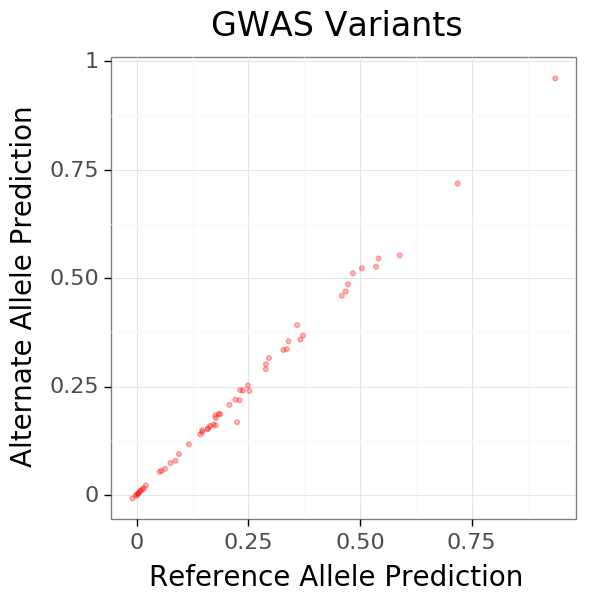

<ggplot: (8786702139368)>

Negative SNPs in Peaks:


CHR   START     END         RSID REF ALT    PVALUE      BETA        SE  \
45  chr4  987663  987664    rs3806758   C   G  0.100219 -0.037952  0.023033   
11  chr4  875994  875995    rs2279185   C   G  0.554847 -0.024914  0.042066   
46  chr4  987673  987674    rs3806759   A   G  0.644937  0.015097  0.032813   
23  chr4  959063  959064  rs143484618   A   G  0.121640  0.175635  0.116098   
16  chr4  957356  957357   rs75854631   A   G  0.106170  0.080468  0.050315   
18  chr4  957778  957779    rs2335500   A   G  0.961210 -0.002649  0.054401   
1   chr4  874986  874987    rs3775131   C   T  0.419328  0.039773  0.049009   
14  chr4  876318  876319    rs3736087   C   T  0.000442  0.087918  0.024840   
38  chr4  987276  987277   rs11936407   C   T  0.004757  0.055141  0.019494   
44  chr4  987554  987555    rs3806757   C   G  0.109142 -0.080699  0.050886   

   PASS  ref_pred  alt_pred     delta  
45    Y  0.224547  0.167794 -0.056753  
11    Y  0.588651  0.552708 -0.035944  
46    Y  0.176607  0.160397 -0.016209  
23    Y  0.252132  0.240044 -0.012087  
16    Y  0.230190  0.218400 -0.011789  
18    Y  0.535821  0.526165 -0.009655  
1     Y  0.171896  0.162573 -0.009323  
14    Y  0.366363  0.358411 -0.007952  
38    Y  0.086862  0.079002 -0.007860  
44    Y  0.158896  0.151452 -0.007444

Positive SNPs in Peaks:


CHR   START     END         RSID REF ALT        PVALUE      BETA  \
47  chr4  987704  987705    rs3806760   A   G  5.847880e-01  0.011547   
26  chr4  960331  960332   rs11248059   C   G  7.720080e-07  0.137055   
37  chr4  987210  987211    rs2276905   C   T  3.077370e-01 -0.155840   
15  chr4  876399  876400    rs3736086   C   T  5.207610e-01 -0.027152   
27  chr4  960542  960543   rs35117553   G   T  2.365500e-01  0.057519   
4   chr4  875155  875156    rs3775129   A   G  4.289400e-04 -0.087336   
12  chr4  876141  876142   rs10902760   C   G  5.229730e-01 -0.027015   
34  chr4  986736  986737  rs115548745   A   G  8.147180e-01 -0.148069   
17  chr4  957598  957599  rs192259574   A   C  7.639040e-01 -0.179317   
3   chr4  875144  875145    rs3775130   A   G  3.748770e-05 -0.121438   

          SE PASS  ref_pred  alt_pred     delta  
47  0.021144    Y  0.176230  0.183620  0.007390  
26  0.027375    Y  0.231686  0.241773  0.010087  
37  0.155903    Y  0.289155  0.301699  0.012543  
15  0.042145    Y  0.473186  0.485901  0.012716  
27  0.048939    Y  0.339727  0.354483  0.014756  
4   0.024621    Y  0.503879  0.523041  0.019162  
12  0.042157    Y  0.296037  0.315951  0.019914  
34  0.623177    Y  0.936729  0.960816  0.024086  
17  0.585179    Y  0.483885  0.511331  0.027446  
3   0.029109    Y  0.359135  0.391748  0.032613

SNPs NOT in Peaks:


(2283, 12)

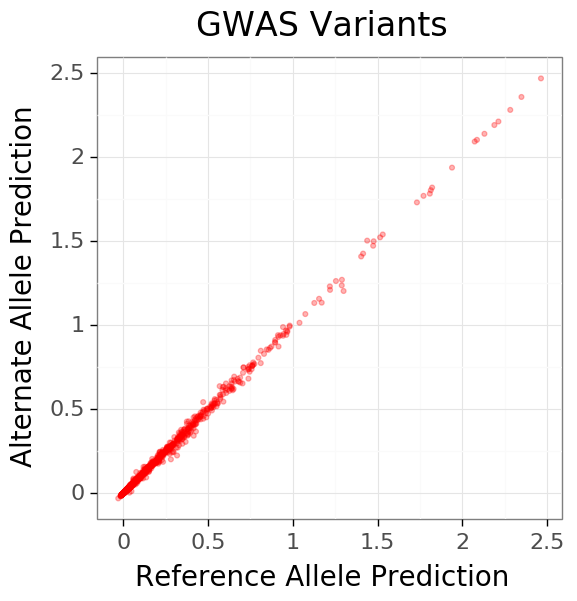

<ggplot: (-9223363250152749245)>

Negative SNPs OUTSIDE Peaks:


CHR     START       END         RSID REF ALT        PVALUE      BETA  \
207   chr4    956364    956365   rs61757581   C   G  4.205890e-01  0.100553   
1333  chr4  90721492  90721493   rs28720123   A   G  2.469290e-02  0.838997   
773   chr4  90607295  90607296   rs11735874   A   C  2.325880e-01  0.081447   
769   chr4  90607077  90607078   rs10029694   C   G  6.572040e-04  0.099345   
213   chr4    961373    961374    rs1377586   A   G  5.111900e-09  0.109895   
1271  chr4  90709594  90709595  rs115322031   C   T  3.383940e-02 -0.168068   
31    chr4    873023    873024   rs77689311   C   T  4.175760e-01  0.039911   
1337  chr4  90721895  90721896   rs28536191   A   G  1.080770e-01 -0.783807   
1149  chr4  90683706  90683707   rs17016107   A   G  3.816100e-01  0.091578   
1593  chr4  90759047  90759048    rs2619363   G   T  1.427720e-08  0.117808   

            SE PASS  ref_pred  alt_pred     delta  
207   0.126414    Y  1.299193  1.204301 -0.094892  
1333  0.426378    Y  0.317217  0.225603 -0.091614  
773   0.068973    Y  0.280873  0.202644 -0.078230  
769   0.029465    Y  0.415504  0.343155 -0.072349  
213   0.018848    Y  0.367904  0.306621 -0.061282  
1271  0.080846    Y  0.428571  0.368327 -0.060245  
31    0.048993    Y  0.738005  0.682714 -0.055291  
1337  0.548018    Y  0.349045  0.295362 -0.053683  
1149  0.105945    Y  0.297399  0.245746 -0.051653  
1593  0.020641    Y  1.288309  1.237454 -0.050855

Positive SNPs OUTSIDE Peaks:


CHR     START       END         RSID REF ALT        PVALUE      BETA  \
253   chr4    971266    971267   rs11731377   G   T  1.386110e-04 -0.095813   
132   chr4    940904    940905   rs35208825   A   G  7.985180e-03  0.092293   
420   chr4  90508045  90508046  rs182778415   A   T  1.631020e-01  0.263486   
279   chr4    979387    979388  rs185055324   C   T  5.735210e-04  0.418104   
1876  chr4  90810732  90810733   rs74664209   C   G  1.338330e-09  0.272700   
2016  chr4  90835558  90835559   rs17806425   C   T  1.356870e-03  0.174296   
934   chr4  90638896  90638897   rs60838312   A   G  5.445150e-01 -0.024937   
60    chr4    901982    901983  rs190834547   A   G  6.898110e-01 -0.056041   
1258  chr4  90705960  90705961  rs143963281   C   T  4.412930e-01 -0.157300   
3     chr4    869169    869170   rs11733713   A   G  5.487240e-05  0.118337   

            SE PASS  ref_pred  alt_pred     delta  
253   0.024939    Y  0.386299  0.428874  0.042575  
132   0.035165    Y  0.592001  0.634890  0.042889  
420   0.195131    Y  0.586825  0.632216  0.045391  
279   0.115711    Y  0.941954  0.989637  0.047683  
1876  0.043602    Y  0.605650  0.654309  0.048659  
2016  0.053331    Y  0.076603  0.127539  0.050935  
934   0.041275    Y  0.375047  0.427790  0.052743  
60    0.139568    Y  1.438204  1.504002  0.065798  
1258  0.208153    Y  0.568373  0.638063  0.069691  
3     0.028998    Y  0.471224  0.543240  0.072015

FOLD:  7
All SNPs:


(5222, 12)

SNPs in Peaks:


(473, 12)

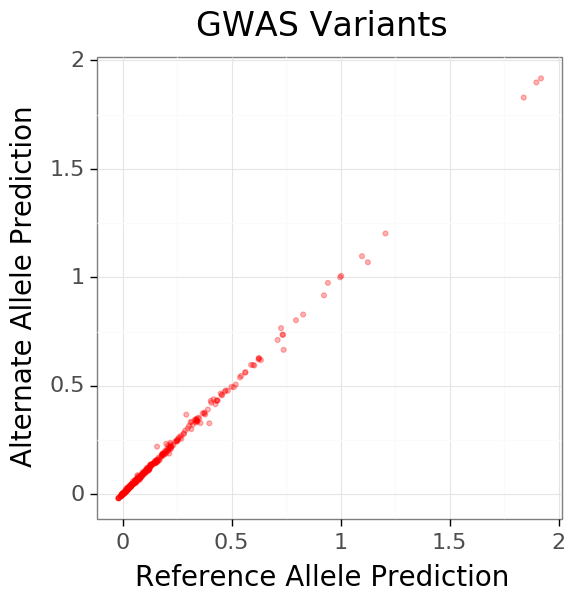

<ggplot: (-9223363250152681556)>

Negative SNPs in Peaks:


CHR     START       END         RSID REF ALT        PVALUE      BETA  \
174  chr17  43909690  43909691  rs116060954   A   G  9.040240e-01 -0.021208   
262  chr17  44024562  44024563   rs62062785   G   T  3.333700e-22 -0.227320   
2    chr17  43394569  43394570  rs115344032   C   G  1.227880e-03  0.301428   
390  chr17  44200015  44200016   rs62061856   C   T  2.687150e-22  0.227719   
250  chr17  44014137  44014138   rs12150460   G   T  4.038280e-22 -0.226906   
0    chr17  43394063  43394064  rs149462394   A   C  1.230650e-03 -0.301259   
196  chr17  43938796  43938797   rs55646970   A   G  3.325480e-22 -0.227446   
161  chr17  43906828  43906829   rs17689882   A   G  1.342250e-22  0.229399   
111  chr17  43791584  43791585    rs1608954   A   G  4.283540e-01 -0.493689   
263  chr17  44024660  44024661   rs62062786   C   G  4.529580e-22  0.226334   

           SE PASS  ref_pred  alt_pred     delta  
174  0.176350    Y  0.738086  0.665615 -0.072471  
262  0.023921    Y  0.397430  0.326880 -0.070550  
2    0.089844    Y  1.124592  1.069286 -0.055305  
390  0.023911    Y  0.356327  0.328127 -0.028200  
250  0.023926    Y  0.213622  0.187241 -0.026381  
0    0.089811    Y  0.509387  0.493145 -0.016242  
196  0.023934    Y  0.633908  0.618392 -0.015516  
161  0.023918    Y  0.314504  0.299963 -0.014541  
111  0.661817    Y  0.268835  0.255403 -0.013432  
263  0.023892    Y  0.518617  0.505411 -0.013206

Positive SNPs in Peaks:


CHR     START       END        RSID REF ALT        PVALUE      BETA  \
27   chr17  43546057  43546058  rs62065399   G   T  1.641740e-21 -0.241974   
64   chr17  43767628  43767629  rs62055752   A   G  2.688420e-22  0.228087   
76   chr17  43778752  43778753  rs62056876   C   T  3.247470e-22 -0.227538   
89   chr17  43784994  43784995  rs62056913   C   T  2.273570e-22 -0.228491   
210  chr17  43983801  43983802  rs62056806   A   G  3.939880e-22 -0.226704   
389  chr17  44199670  44199671  rs62061855   A   G  7.115390e-22  0.225965   
198  chr17  43938997  43938998    rs734629   A   C  7.653870e-01  0.144327   
20   chr17  43483774  43483775   rs1230101   A   G  1.069460e-02 -0.051516   
338  chr17  44121917  44121918  rs77768866   C   T  2.510300e-22 -0.227852   
261  chr17  44024552  44024553  rs62062784   C   G  3.332810e-22 -0.227322   

           SE PASS  ref_pred  alt_pred     delta  
27   0.025985    Y  0.218202  0.237577  0.019375  
64   0.023950    Y  0.311010  0.330907  0.019897  
76   0.023938    Y  0.067692  0.087670  0.019978  
89   0.023952    Y  0.417068  0.438006  0.020939  
210  0.023898    Y  0.404029  0.430631  0.026602  
389  0.023969    Y  0.199284  0.232336  0.033052  
198  0.475459    Y  0.941123  0.974248  0.033125  
20   0.020132    Y  0.726216  0.765662  0.039446  
338  0.023909    Y  0.157499  0.219270  0.061771  
261  0.023922    Y  0.291496  0.366736  0.075239

SNPs NOT in Peaks:


(4749, 12)

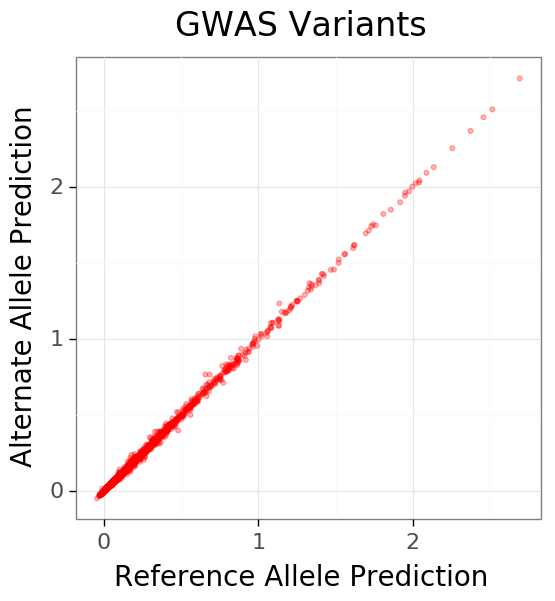

<ggplot: (8786828092799)>

Negative SNPs OUTSIDE Peaks:


CHR     START       END         RSID REF ALT        PVALUE      BETA  \
251   chr17  43508303  43508304   rs34018943   A   G  4.345530e-21 -0.238910   
1024  chr17  43783370  43783371    rs6503444   C   T  7.243710e-01 -0.012226   
1968  chr17  43930262  43930263  rs183338496   C   G  1.146550e-01 -0.359248   
4079  chr17  44249838  44249839    rs9911018   C   T  3.050030e-01  0.129542   
1147  chr17  43799810  43799811   rs76667867   C   G  3.947480e-22  0.227029   
1356  chr17  43829404  43829405    rs1880755   C   T  1.418830e-08  0.107805   
1307  chr17  43823084  43823085    rs8071902   A   G  6.604970e-01 -0.140157   
2798  chr17  44051513  44051514  rs112165071   A   G  9.574640e-01  0.016743   
272   chr17  43514954  43514955   rs62064655   A   G  3.846580e-21  0.239334   
1297  chr17  43821478  43821479    rs8082105   A   G  3.243470e-02 -0.050907   

            SE PASS  ref_pred  alt_pred     delta  
251   0.025929    Y  0.480912  0.401414 -0.079498  
1024  0.034624    Y  0.773244  0.714608 -0.058636  
1968  0.218883    Y  0.560708  0.503381 -0.057326  
4079  0.124182    Y  0.919044  0.864726 -0.054317  
1147  0.023934    Y  0.257934  0.208334 -0.049600  
1356  0.019046    Y  1.133288  1.088189 -0.045099  
1307  0.313098    Y  0.360392  0.315732 -0.044660  
2798  0.316662    Y  0.365686  0.323037 -0.042648  
272   0.025940    Y  0.266978  0.225129 -0.041849  
1297  0.023700    Y  0.173268  0.132271 -0.040997

Positive SNPs OUTSIDE Peaks:


CHR     START       END        RSID REF ALT        PVALUE      BETA  \
2313  chr17  43973652  43973653  rs62056780   C   T  3.938360e-22 -0.226705   
2676  chr17  44031596  44031597    rs878918   A   G  1.638560e-05  0.086030   
2083  chr17  43945100  43945101  rs11869096   A   G  2.069490e-03 -0.057993   
2084  chr17  43945106  43945107  rs62055475   C   T  3.880030e-22  0.226886   
1529  chr17  43853072  43853073  rs35152905   G   T  3.004800e-02 -0.055595   
3809  chr17  44208144  44208145  rs17661428   C   G  4.018590e-22 -0.227792   
3104  chr17  44094667  44094668   rs2316948   C   G  2.222920e-22 -0.228177   
1212  chr17  43810608  43810609  rs62054394   A   T  2.953920e-22  0.227674   
2323  chr17  43974889  43974890  rs62056784   C   G  3.938970e-22 -0.226704   
2299  chr17  43971785  43971786  rs11575895   A   G  3.939740e-22 -0.226704   

            SE PASS  ref_pred  alt_pred     delta  
2313  0.023898    Y  0.889034  0.938016  0.048981  
2676  0.019890    Y  0.472700  0.522434  0.049733  
2083  0.018814    Y  0.822121  0.878636  0.056515  
2084  0.023913    Y  0.766656  0.825193  0.058537  
1529  0.025500    Y  0.297303  0.357634  0.060331  
3809  0.024019    Y  0.178671  0.239764  0.061093  
3104  0.023913    Y  0.331072  0.393265  0.062193  
1212  0.023930    Y  0.684860  0.767847  0.082987  
2323  0.023898    Y  1.136244  1.235697  0.099453  
2299  0.023898    Y  0.657250  0.768721  0.111470

FOLD:  8
All SNPs:


(4093, 12)

SNPs in Peaks:


(136, 12)

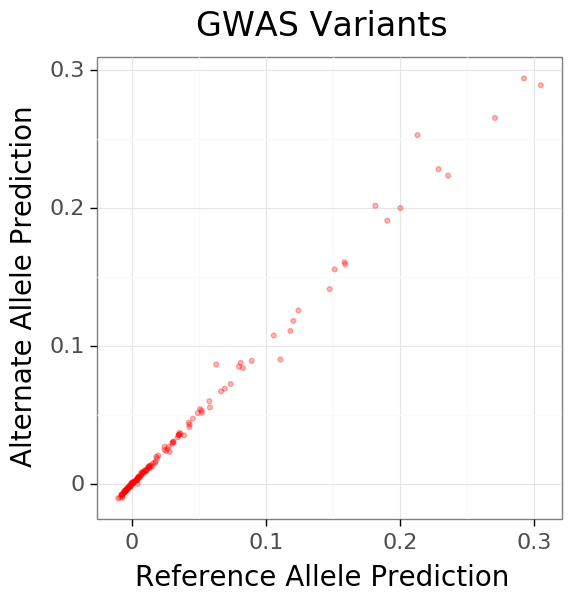

<ggplot: (8786677252307)>

Negative SNPs in Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
60   chr12   41312147   41312148    rs1372543   A   G  0.509090 -0.031469   
88   chr12   41459242   41459243  rs181012052   C   T  0.683461  0.066059   
74   chr12   41407403   41407404     rs278899   A   G  0.005572  0.061770   
130  chr12  123268884  123268885   rs75875275   A   G  0.106533  0.065856   
119  chr12   42300681   42300682   rs17576430   C   T  0.430900 -0.146159   
59   chr12   41311737   41311738   rs73126511   C   T  0.888058 -0.010252   
58   chr12   41311589   41311590   rs10784949   A   G  0.319568  0.019300   
103  chr12   41477220   41477221  rs185511401   C   T  0.387408 -0.111650   
9    chr12   34123490   34123491  rs142024504   A   G  0.937564 -0.018390   
84   chr12   41438385   41438386   rs10879578   G   T  0.041140 -0.062255   

           SE PASS  ref_pred  alt_pred     delta  
60   0.047479    Y  0.110770  0.090394 -0.020376  
88   0.160853    Y  0.304854  0.289218 -0.015636  
74   0.022185    Y  0.235736  0.223660 -0.012076  
130  0.040486    Y  0.118213  0.111094 -0.007119  
119  0.182091    Y  0.147516  0.141448 -0.006068  
59   0.072930    Y  0.270648  0.265506 -0.005143  
58   0.019403    Y  0.028281  0.023356 -0.004924  
103  0.130896    Y  0.004297  0.000188 -0.004109  
9    0.232488    Y  0.039034  0.035314 -0.003720  
84   0.030289    Y -0.007096 -0.009904 -0.002808

Positive SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
128  chr12  123268777  123268778    rs1696355   A   T  1.869780e-01  0.050976   
56   chr12   41311418   41311419   rs10506179   C   T  3.187960e-01  0.019336   
53   chr12   41311120   41311121   rs56294359   C   T  3.036750e-01 -0.019400   
48   chr12   40921830   40921831  rs150842995   A   G  2.562610e-01 -0.749163   
75   chr12   41408134   41408135     rs397967   A   G  2.227530e-09 -0.333909   
78   chr12   41408811   41408812     rs278900   A   T  5.234740e-06  0.186955   
117  chr12   42300417   42300418   rs74658662   G   T  4.308650e-01  0.146171   
122  chr12  123238416  123238417   rs79350782   G   T  1.216290e-01  0.064001   
54   chr12   41311339   41311340  rs187801857   A   T  5.163180e-01 -0.192545   
77   chr12   41408740   41408741   rs35862989   A   T  4.578600e-02 -0.086695   

           SE PASS  ref_pred  alt_pred     delta  
128  0.038865    Y  0.049232  0.051523  0.002292  
56   0.019409    Y  0.158507  0.160897  0.002390  
53   0.018857    Y  0.024465  0.027097  0.002633  
48   0.732634    Y  0.050910  0.054416  0.003506  
75   0.053696    Y  0.151154  0.155725  0.004570  
78   0.040175    Y  0.079899  0.085245  0.005346  
117  0.182091    Y  0.081161  0.087971  0.006810  
122  0.041032    Y  0.181541  0.201833  0.020292  
54   0.304514    Y  0.062967  0.086760  0.023793  
77   0.043869    Y  0.212883  0.253064  0.040181

SNPs NOT in Peaks:


(3957, 12)

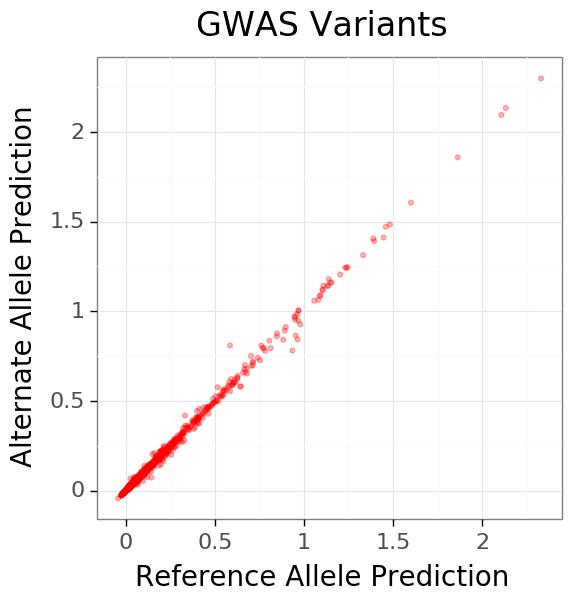

<ggplot: (8786677330552)>

Negative SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT        PVALUE  \
3925  chr12  123337761  123337762   rs12298151   A   G  6.186260e-01   
1629  chr12   40413305   40413306   rs28370664   A   C  1.753300e-20   
2298  chr12   40894172   40894173   rs17597637   G   T  3.290310e-01   
3770  chr12  123303945  123303946    rs1798569   A   C  8.556560e-01   
3948  chr12  123342229  123342230    rs1587856   A   G  6.940980e-01   
3881  chr12  123326326  123326327     rs897392   A   G  5.222260e-01   
1908  chr12   40732123   40732124    rs4767972   C   T  1.455140e-01   
3208  chr12   41462234   41462235     rs166806   C   T  7.904560e-02   
3402  chr12   42149726   42149727  rs118167883   C   T  8.941480e-01   
62    chr12   33200884   33200885   rs10844438   G   T  2.493900e-02   

          BETA        SE PASS  ref_pred  alt_pred     delta  
3925 -0.019407  0.038896    Y  0.935479  0.780633 -0.154846  
1629 -0.502667  0.051311    Y  0.964243  0.843413 -0.120830  
2298 -0.025448  0.026134    Y  0.954108  0.864381 -0.089728  
3770 -0.011185  0.061397    Y  0.143751  0.073227 -0.070524  
3948  0.011758  0.029932    Y  0.646789  0.580724 -0.066065  
3881 -0.017940  0.028083    Y  0.641183  0.580929 -0.060254  
1908 -0.038195  0.026148    Y  0.254381  0.200529 -0.053852  
3208  0.050942  0.028856    Y  0.979050  0.927005 -0.052046  
3402  0.013411  0.100626    Y  0.196826  0.145989 -0.050837  
62    0.042965  0.019146    Y  0.329482  0.281835 -0.047647

Positive SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
1708  chr12   40438429   40438430   rs10878031   A   T  0.130339 -0.028517   
3048  chr12   41401999   41402000   rs10879518   C   G  0.075285  0.049666   
1940  chr12   40737075   40737076   rs17461964   C   T  0.145592 -0.038182   
3859  chr12  123320874  123320875   rs79355888   C   T  0.775812  0.105058   
1579  chr12   40397235   40397236   rs28370644   C   T  0.063192  0.052799   
3567  chr12   43054197   43054198  rs188012290   A   G  0.949234 -0.007650   
3584  chr12  123225533  123225534  rs139695358   C   T  0.556668  0.165595   
2182  chr12   40840033   40840034    rs1346309   C   G  0.072099  0.033944   
1068  chr12   34417692   34417693   rs12824730   C   T  0.288800  0.039501   
1941  chr12   40737115   40737116   rs10784518   G   T  0.145578 -0.038183   

            SE PASS  ref_pred  alt_pred     delta  
1708  0.018842    Y  0.025451  0.067075  0.041624  
3048  0.027785    Y  0.412418  0.455079  0.042661  
1940  0.026144    Y  0.399728  0.444286  0.044558  
3859  0.363941    Y  0.760579  0.809223  0.048644  
1579  0.028573    Y  0.702586  0.751713  0.049127  
3567  0.120559    Y  0.160402  0.210014  0.049612  
3584  0.275913    Y  0.148929  0.203854  0.054925  
2182  0.018883    Y  0.515390  0.576284  0.060894  
1068  0.037388    Y  0.331826  0.418807  0.086981  
1941  0.026144    Y  0.584631  0.809750  0.225119

FOLD:  9
All SNPs:


(323, 12)

SNPs in Peaks:


(43, 12)

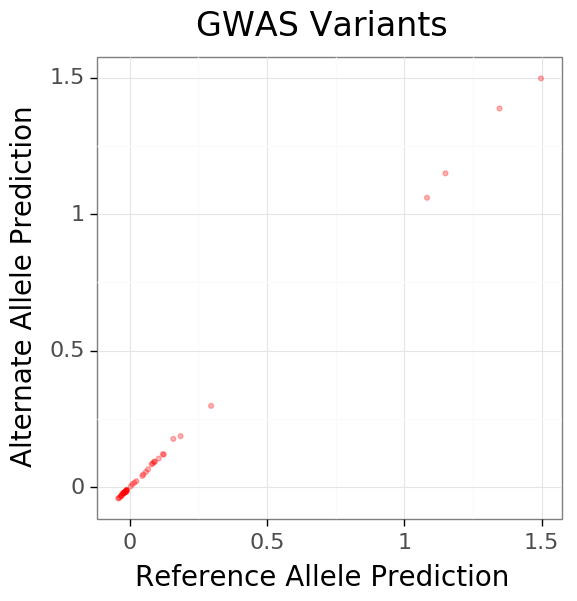

<ggplot: (8786702027128)>

Negative SNPs in Peaks:


CHR      START        END         RSID REF ALT        PVALUE      BETA  \
9   chr10  121368348  121368349  rs115879160   G   T  8.644330e-01 -0.026199   
28  chr10  121532890  121532891  rs144030311   A   G  9.665760e-01  0.008238   
21  chr10  121458850  121458851  rs117953397   C   G  9.221510e-02 -0.063552   
17  chr10  121369051  121369052    rs7075463   A   C  7.305470e-01  0.007336   
34  chr10  121536635  121536636   rs72826422   C   G  6.396350e-02 -0.071163   
3   chr10  121292329  121292330  rs185953720   G   T  9.753270e-01 -0.004413   
22  chr10  121458911  121458912  rs192486997   C   T  2.886300e-01 -0.151916   
6   chr10  121292936  121292937   rs79210761   C   T  9.462420e-01 -0.004115   
15  chr10  121368873  121368874  rs145701507   C   T  5.835250e-01 -0.159246   
32  chr10  121536327  121536328  rs117896735   A   G  1.754070e-09 -0.449792   

          SE PASS  ref_pred  alt_pred     delta  
9   0.153915    Y  1.082559  1.060187 -0.022372  
28  0.197415    Y -0.012074 -0.017695 -0.005621  
21  0.037469    Y  0.045933  0.041373 -0.004560  
17  0.021312    Y  0.124028  0.119658 -0.004370  
34  0.038100    Y  0.059348  0.056321 -0.003027  
3   0.143041    Y  0.049378  0.046814 -0.002564  
22  0.146046    Y  0.024601  0.022321 -0.002280  
6   0.060907    Y -0.034838 -0.035807 -0.000969  
15  0.296942    Y  0.066825  0.065866 -0.000958  
32  0.071012    Y -0.016993 -0.017728 -0.000735

Positive SNPs in Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
13  chr10  121368582  121368583  rs142590307   C   T  0.875046  0.034921   
2   chr10  121292123  121292124   rs10787976   A   G  0.277104  0.036571   
8   chr10  121368169  121368170   rs11199044   A   C  0.739901  0.013698   
40  chr10  121710444  121710445    rs2420792   A   G  0.651818  0.009404   
37  chr10  121663221  121663222  rs188110292   A   G  0.132260  0.487241   
27  chr10  121532886  121532887   rs61867903   G   T  0.310642 -0.044365   
18  chr10  121369103  121369104  rs138715304   G   T  0.306950 -0.070275   
16  chr10  121369014  121369015   rs12416614   C   T  0.848030 -0.032586   
14  chr10  121368847  121368848    rs7075175   C   G  0.734674 -0.007222   
12  chr10  121368477  121368478   rs11199045   C   G  0.170513  0.030679   

          SE PASS  ref_pred  alt_pred     delta  
13  0.222869    Y  0.091692  0.093240  0.001548  
2   0.033790    Y  0.009954  0.011566  0.001612  
8   0.041330    Y  0.296356  0.298158  0.001802  
40  0.020851    Y  0.185228  0.187220  0.001993  
37  0.307452    Y  0.084018  0.087330  0.003311  
27  0.043523    Y -0.026893 -0.022242  0.004651  
18  0.069407    Y  0.079524  0.084192  0.004668  
16  0.170783    Y  0.088441  0.093406  0.004965  
14  0.021319    Y  0.158656  0.177184  0.018528  
12  0.022435    Y  1.346423  1.387199  0.040776

SNPs NOT in Peaks:


(280, 12)

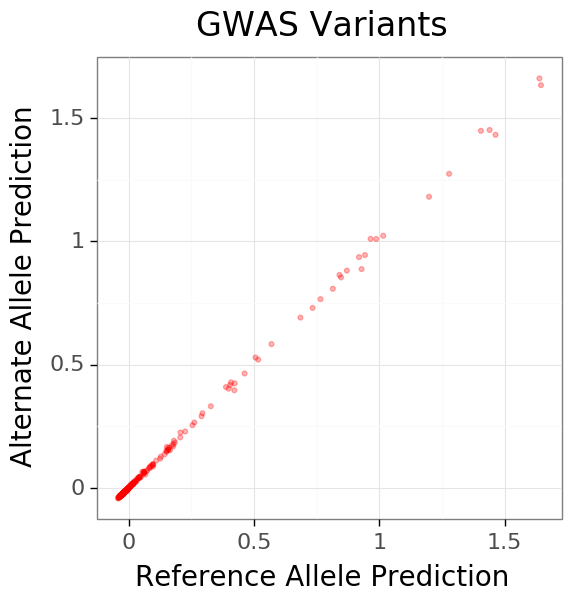

<ggplot: (8786677298717)>

Negative SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
116  chr10  121410904  121410905  rs192502283   C   G  0.079809 -0.183773   
82   chr10  121376917  121376918   rs11199049   A   G  0.145982 -0.030658   
160  chr10  121464050  121464051   rs17099211   C   G  0.068557 -0.069240   
197  chr10  121655932  121655933    rs7084324   C   G  0.000031  0.117998   
120  chr10  121411861  121411862     rs196335   C   T  0.767136  0.009306   
219  chr10  121659957  121659958   rs71482901   A   G  0.510371 -0.027022   
64   chr10  121373474  121373475   rs11199046   C   G  0.502958  0.013896   
208  chr10  121658842  121658843   rs12257358   A   C  0.000735  0.077735   
63   chr10  121373469  121373470   rs75952843   C   G  0.283884  0.073726   
128  chr10  121414598  121414599   rs12250770   C   T  0.002635 -0.065469   

           SE PASS  ref_pred  alt_pred     delta  
116  0.102930    Y  0.929354  0.887104 -0.042251  
82   0.021127    Y  1.463861  1.431574 -0.032287  
160  0.037712    Y  0.421588  0.395964 -0.025624  
197  0.028010    Y  1.198567  1.180350 -0.018217  
120  0.031394    Y  1.645306  1.632846 -0.012460  
219  0.040917    Y  0.066337  0.054246 -0.012090  
64   0.020730    Y  0.164410  0.152846 -0.011564  
208  0.023169    Y  0.096449  0.086340 -0.010108  
63   0.069449    Y  0.177238  0.167967 -0.009271  
128  0.021867    Y  0.814423  0.807388 -0.007035

Positive SNPs OUTSIDE Peaks:


CHR      START        END         RSID REF ALT    PVALUE      BETA  \
11   chr10  121296385  121296386    rs2277267   A   G  0.818605 -0.036102   
264  chr10  121712667  121712668   rs12775642   A   G  0.155717 -0.029580   
133  chr10  121415685  121415686   rs72840788   A   G  0.000068 -0.090207   
25   chr10  121298567  121298568   rs76021313   C   T  0.596301 -0.062890   
198  chr10  121656067  121656068   rs35225459   A   G  0.506163 -0.027262   
84   chr10  121377046  121377047   rs11199050   C   T  0.429689 -0.016900   
126  chr10  121414205  121414206  rs148789629   C   T  0.023714 -0.361682   
127  chr10  121414236  121414237     rs196336   C   T  0.804786 -0.004853   
121  chr10  121412132  121412133   rs55725412   A   G  0.138118 -0.030363   
118  chr10  121411631  121411632  rs112168846   A   G  0.416034  0.041580   

           SE PASS  ref_pred  alt_pred     delta  
11   0.158173    Y  0.919091  0.935760  0.016669  
264  0.020811    Y  0.206434  0.224658  0.018224  
133  0.022506    Y  0.408366  0.428009  0.019643  
25   0.117769    Y  0.388215  0.408854  0.020639  
198  0.040872    Y  1.639045  1.660244  0.021199  
84   0.021376    Y  0.987876  1.009165  0.021289  
126  0.152992    Y  0.841013  0.863538  0.022526  
127  0.019640    Y  0.505865  0.528713  0.022848  
121  0.020508    Y  1.405548  1.447727  0.042179  
118  0.051391    Y  0.965275  1.009664  0.044389

In [8]:
get_results_all_folds('PD_CTRL_MDTG')

In [ ]:
get_results_all_folds('PD_GBA1_MDTG')

In [ ]:
get_results_all_folds('PD_CTRL_SUNI')

In [ ]:
get_results_all_folds('PD_GBA1_SUNI')

In [ ]:
get_results_all_folds('AD_CTRL_PARL')

In [ ]:
get_results_all_folds('AD_ADAD_PARL')

In [ ]:
get_results_all_folds('AD_CTRL_HIPP')

In [ ]:
get_results_all_folds('AD_ADAD_HIPP')

In [ ]:
get_results_all_folds('PD_CTRL_HIPP')

In [ ]:
get_results_all_folds('PD_GBA1_HIPP')

In [ ]:
get_results_all_folds('AD_CTRL_SMTG')

In [ ]:
get_results_all_folds('AD_ADAD_SMTG')